In [1]:
import math
import os
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
from sympy import *
from scipy.optimize import brentq
from scipy.interpolate import CubicSpline, splev, splrep

from openalea.archicrop.archicrop import ArchiCrop
from openalea.archicrop.stics_io import read_sti_file, get_stics_data
from openalea.archicrop.cereal_axis import bell_shaped_dist, geometric_dist
from openalea.archicrop.cereal_leaf import sr_dornbush
from openalea.archicrop.growth import demand_dist, equal_dist
from openalea.archicrop.simulation import resolve_organ_growth, compute_skew

from ipywidgets import interact, interactive, IntSlider, FloatSlider, fixed, Play, HBox, VBox, jslink

In [2]:
def stics_output(tec_file, plant_file, stics_output_file):
    """Extract relevant data from STICS output files."""

    density, daily_dynamics, lifespan, lifespan_early = get_stics_data(
        file_tec_xml=tec_file,  # Path to the STICS management XML file
        file_plt_xml=plant_file,  # Path to the STICS plant XML file
        stics_output_file=stics_output_file  # Path to the STICS output file
    )

    thermal_time = [value["Thermal time"] for value in daily_dynamics.values()]
    leaf_area_plant = [value["Plant leaf area"] for value in daily_dynamics.values()]
    sen_leaf_area_plant = [value["Plant senescent leaf area"] for value in daily_dynamics.values()]
    height_canopy = [value["Plant height"] for value in daily_dynamics.values()]

    for key, value in daily_dynamics.items():
        if value["Phenology"] == 'juvenile':
            next_key = key + 1
            if next_key in daily_dynamics and daily_dynamics[next_key]["Phenology"] == 'exponential':
                end_juv = thermal_time[key-1] + thermal_time[0]

        elif value["Phenology"] == 'exponential':
            next_key = key + 1
            if next_key in daily_dynamics and daily_dynamics[next_key]["Phenology"] == 'repro':
                end_veg = thermal_time[key-1] + thermal_time[0]
                index_end_veg = key - 1
                break

    return density, daily_dynamics, lifespan, lifespan_early, thermal_time, leaf_area_plant, sen_leaf_area_plant, height_canopy, end_juv, end_veg, index_end_veg

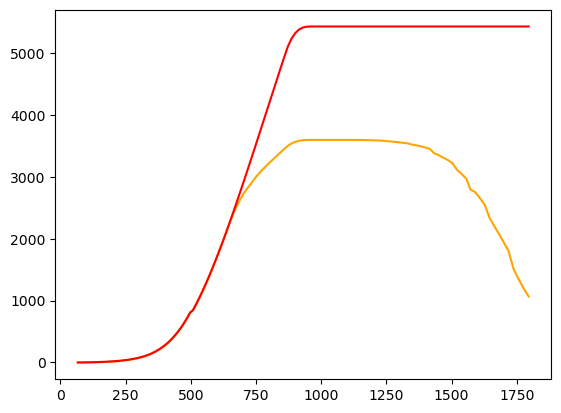

In [3]:
tec_file='D:/ArchiCrop/data/02NT18SorgV2D1_tec.xml'
plant_file='D:/ArchiCrop/data/sorgho_imp_M_v10_plt.xml'
stics_output_file='D:/ArchiCrop/data/mod_s02NT18SorgV2D1.sti'
stics_output_file_pot='D:/ArchiCrop/data/mod_s02NT18SorgV2D1_no_stress.sti'

density, daily_dynamics, lifespan, lifespan_early, thermal_time, leaf_area_plant, sen_leaf_area_plant, height_canopy, end_juv, end_veg, index_end_veg = stics_output(tec_file, plant_file, stics_output_file)
density_pot, daily_dynamics_pot, lifespan_pot, lifespan_early_pot, thermal_time_pot, leaf_area_plant_pot, sen_leaf_area_plant_pot, height_canopy_pot, end_juv_pot, end_veg_pot, index_end_veg_pot = stics_output(tec_file, plant_file, stics_output_file_pot)

# plt.plot(thermal_time[:index_end_veg+2], leaf_area_plant[:index_end_veg+2], color="black")
plt.plot(thermal_time, [la-sen for la,sen in zip(leaf_area_plant, sen_leaf_area_plant)], color="orange")
plt.plot(thermal_time, [la-sen for la,sen in zip(leaf_area_plant_pot, sen_leaf_area_plant_pot)], color="red")
plt.show()

In [4]:
def linear_leaf_growth_and_pot(nb_phy, ligul_factor, daily_dynamics, thermal_time, leaf_area_plant, height_canopy, end_veg, index_end_veg, pot_factor, pot=False):

    # nb_phy = math.floor((end_veg-thermal_time[0]-ligulochron)/phyllochron)
    phyllochron = (end_veg-thermal_time[0])/(nb_phy + ligul_factor)
    # print(phyllochron)
    ligulochron = phyllochron * ligul_factor
    # print(ligulochron)

    leaf_area_plant = leaf_area_plant[:index_end_veg+1]
    thermal_time = thermal_time[:index_end_veg+1]
    # print('offset', thermal_time[0])
    spl = splrep(thermal_time, leaf_area_plant)
    # scaled_leaf_areas = bell_shaped_dist(Smax, nb_phy, rmax, skew)

    # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), width_ratios=[2,1])
    # ax1.scatter(thermal_time, leaf_area_plant, color="orange", label="STICS")
    ax1.plot(thermal_time, leaf_area_plant, linewidth=6, color="orange", label="STICS")

 
    starts = []
    ends = []

    for i in range(nb_phy):
        start = i * phyllochron + thermal_time[0]
        # print(start, round(start))
        end = start + ligulochron
        
        starts.append(round(start))
        ends.append(round(end))

    # print(ends[-1], round(thermal_time[-1]))
    
    la_starts = splev(starts, spl)
    la_ends = splev(ends, spl)

    # leaf_areas = [0]*nb_phy
    # for j,(s,e) in enumerate(zip(la_starts,la_ends)):
    #     if j == 0:
    #         leaf_areas[j] += e
    #     elif 0 < j < len(la_starts)-1:
    #         leaf_areas[j] += e - sum(leaf_areas)
    #     else: 
    #         leaf_areas[j] += e - sum(leaf_areas)
    # # for j,(s,e) in enumerate(zip(la_starts,la_ends)):
    # #     if j < len(la_starts)-1:
    # #         leaf_areas[j] -= (ends[j]-starts[j+1])/(ends[j+1]-starts[j+1]) * leaf_areas[j+1]


    leaf_areas = resolve_organ_growth(nb_phy, ligul_factor, la_ends)
            
    # for i,la in enumerate(leaf_areas):
    #     if i == 0:
    #         ax1.plot(np.linspace(starts[i], ends[i], 2), [0, leaf_areas[i]], color="#BF864D", linewidth=2, label="Linear leaf growth")
    #     else:
    #         ax1.plot(np.linspace(starts[i], ends[i], 2), [sum(leaf_areas[:i]), sum(leaf_areas[:i+1])], linewidth=2, color="#BF864D")

    range_tt = range(round(thermal_time[0]), round(thermal_time[-1])+1)
    interp_la = splev(range_tt, spl)
    rates_la = [interp_la[i]-interp_la[i-1] if i > 0 else 0 for i in range(len(interp_la))]
    # ax3 = ax1.twinx()
    # ax3.plot(range_tt, rates_la, linestyle="--", color="black", label="Growth rate STICS")

    S = []
    for t in range(max(ends)):
        sum_temp = 0
        for i,(s,e) in enumerate(zip(starts,ends)):
            if s <= t < e:
                sum_temp += (t-s)/(e-s) * leaf_areas[i]
            elif t >= e:
                sum_temp += leaf_areas[i]
        S.append(sum_temp)
    
    # ax1.plot(starts, la_starts)
    # ax1.plot(ends, la_ends)
    ax1.set_xlabel("Thermal time (°C.d)", fontsize=24, fontname="Times New Roman")
    ax1.set_ylabel("Plant leaf surface (cm²)", fontsize=24, fontname="Times New Roman")
    # ax1.fill_between(range(int(thermal_time[0]),len(S)), [0]*(len(S)-int(thermal_time[0])), S[int(thermal_time[0]):], color="#BF864D", alpha=0.15, label="Cumulated sum of leaf areas")
    
    # ax3.legend()


    # fig2, ax2 = plt.subplots(figsize=(12,6))
    
    for i, la in enumerate(leaf_areas):
        if la == max(leaf_areas):
            id_max = i+1
            break

    # print(id_max-1/nb_phy)
    rmax_int = np.arange(max(0,(id_max-1)/nb_phy), min(1,(id_max+1)/nb_phy), 0.02)
    # print("rmax int", rmax_int)
   
    leaf_areas_norm = [la/max(leaf_areas) for la in leaf_areas]
    
    skews_rmax = {}
    id = 0
    for rank in range(1, nb_phy+1):
        for rmax in rmax_int:
            if rmax != rank/nb_phy and leaf_areas[rank-1] > 0:
                skew = compute_skew(rank=rank, nb_phy=nb_phy, rmax=rmax, leaf_areas=leaf_areas_norm)
                if 1e-10 < skew < 1.0:
                    skews_rmax[id] = (skew, rmax)
                    id += 1

    # skew_int = [np.median(skews), max(skews)*1.3]
    # skews = [s[0] for s in skews_rmax]
    # skew_int = [min(skews), max(skews)]
    # print("Skews and rmax", skews_rmax)
    # plt.plot(range(len(skews)), skew_int)
    # plt.show()

    skew_int = []
    rejected_skews = []
    label_green_set = False
    label_grey_set = False
    mtgs = {}
    # realized_la = {}
    for id,(skew,rmax) in skews_rmax.items():
        bell_shaped_leaf_areas = bell_shaped_dist(leaf_area_plant[-1]*pot_factor, nb_phy, rmax, skew)
        for i,bs in enumerate(bell_shaped_leaf_areas):
            if bs < leaf_areas[i]: #-(0.05*max(leaf_areas)):
                color = "grey"
                break
            else:
                color = "black"
        if color == "black":
            S = []
            for t in range(max(ends)):
                sum_temp = 0
                for i,(s,e) in enumerate(zip(starts,ends)):
                    if s <= t < e:
                        sum_temp += (t-s)/(e-s) * bell_shaped_leaf_areas[i]
                    elif t >= e:
                        sum_temp += bell_shaped_leaf_areas[i]
                S.append(sum_temp)

            
            plant = ArchiCrop(daily_dynamics=daily_dynamics, leaf_area=leaf_area_plant[-1]*pot_factor, height=height_canopy[-1]*pot_factor, 
                                nb_phy=nb_phy, phyllochron=phyllochron, leaf_duration=ligul_factor)
            plant.generate_potential_plant()
            growing_plant = plant.grow_plant(rate=False, distribution_function=demand_dist)
            growing_plant_mtg = list(growing_plant.values())
            mtgs[id] = growing_plant_mtg
             
        if color == "black" and not label_green_set:
            # ax2.plot(bell_shaped_leaf_areas, range(1,nb_phy+1), color=color, linestyle='dotted', alpha=0.7, label="Viable")
            # ax1.plot(range(int(thermal_time[0]),len(S)), S[int(thermal_time[0]):], color=color, linestyle='dotted', alpha=0.7, label="Viable")
            ax1.plot(thermal_time,[sum(la 
                                for la in gp.properties()["visible_leaf_area"].values()) 
                                for gp in growing_plant_mtg[:index_end_veg+1]], color="green", label="Simulated")
            label_green_set = True
        elif color == "black":
            # ax2.plot(bell_shaped_leaf_areas, range(1,nb_phy+1), color=color, linestyle='dotted', alpha=0.7)
            # ax1.plot(range(int(thermal_time[0]),len(S)), S[int(thermal_time[0]):], color=color, linestyle='dotted', alpha=0.7)
            ax1.plot(thermal_time,[sum(la 
                                for la in gp.properties()["visible_leaf_area"].values()) 
                                for gp in growing_plant_mtg[:index_end_veg+1]], color="green")
        elif color == "grey" and not label_grey_set:
            ax2.plot(bell_shaped_leaf_areas, range(1,nb_phy+1), alpha=0, color=color) #, label="Non-viable")
            label_grey_set = True
        else:
            ax2.plot(bell_shaped_leaf_areas, range(1,nb_phy+1), alpha=0, color=color)
        if color == "black":
            skew_int.append(skew)
        else:
            rejected_skews.append(skew)

    # skew_int.sort()
    # print(skew_int)
    # rejected_skews.sort()
    # print(rejected_skews)
            
    # ax2.plot([id_max,id_max], [0,max(leaf_areas)], color="black", linestyle="--")
    # ax2.fill_between([id_max-1,id_max+1], [0]*2, [max(leaf_areas)*pot_factor**2]*2, color="green", alpha=0.15, label="Viable range for rmax")
    # ax2.plot(leaf_areas, range(1,nb_phy+1), color="#BF864D", linestyle="-")
    # ax2.scatter(leaf_areas, range(1,nb_phy+1), color="#BF864D", label="For linear leaf growth")


    first = True
    for id in mtgs:
        visible_leaf_areas = []

        for leaf in mtgs[id][-32].properties()["visible_leaf_area"]:
            visible_leaf_areas.append(mtgs[id][-32].properties()["visible_leaf_area"][leaf])
        # bell_shape = bell_shaped_dist(params_sets[id]['leaf_area'], params_sets[id]['nb_phy'], params_sets[id]['rmax'], params_sets[id]['skew'])

        if first:
            ax2.plot(visible_leaf_areas, range(1, nb_phy + 1), color="green", label="Simulated")
            first = False
        else:
            ax2.plot(visible_leaf_areas, range(1, nb_phy + 1), color="green")



    # ax2.plot(leaf_areas, range(1,nb_phy+1), color="#BF864D", linestyle="-")
    # ax2.scatter(leaf_areas, range(1,nb_phy+1), color="#BF864D", label="Linear")
    ax2.set_ylabel("Leaf rank", fontsize=24, fontname="Times New Roman")
    ax2.set_xlabel("Leaf surface (cm²)", fontsize=24, fontname="Times New Roman")
    ax2.legend(fontsize=14, loc="lower right")
    ax1.legend(fontsize=14)


    # print("bell shape :", sum(bell_shaped_leaf_areas))
    # print("per leaf from stics :", sum(leaf_areas))
    # print("for plant from stics :", leaf_area_plant[-1])
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    today_str = date.today().strftime("%Y-%m-%d")
    os.makedirs(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}", exist_ok=True)  # noqa: PTH103
    plt.savefig(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}/leaf_growth_pot{pot}_N{nb_phy}_pot_factor_{pot_factor}.png")
    plt.show()

interact(linear_leaf_growth_and_pot, 
         nb_phy = IntSlider(min=10,max=40,step=1,value=16), 
         ligul_factor = FloatSlider(min=1.0,max=3.0,step=0.1,value=1.6),
         daily_dynamics = fixed(daily_dynamics),
         thermal_time = fixed(thermal_time), 
         leaf_area_plant = fixed(leaf_area_plant), 
         height_canopy = fixed(height_canopy),
         end_veg = fixed(end_veg), 
         index_end_veg = fixed(index_end_veg),
         pot_factor = FloatSlider(min=1.0,max=3.0,step=0.05,value=1.4))

interactive(children=(IntSlider(value=16, description='nb_phy', max=40, min=10), FloatSlider(value=1.6, descri…

<function __main__.linear_leaf_growth_and_pot(nb_phy, ligul_factor, daily_dynamics, thermal_time, leaf_area_plant, height_canopy, end_veg, index_end_veg, pot_factor, pot=False)>

In [5]:
interact(linear_leaf_growth_and_pot, 
         nb_phy = IntSlider(min=10,max=40,step=1,value=16), 
         ligul_factor = FloatSlider(min=1.0,max=3.0,step=0.1,value=1.6),
         daily_dynamics = fixed(daily_dynamics_pot),
         thermal_time = fixed(thermal_time_pot), 
         leaf_area_plant = fixed(leaf_area_plant_pot), 
         height_canopy = fixed(height_canopy_pot),
         end_veg = fixed(end_veg_pot), 
         index_end_veg = fixed(index_end_veg_pot),
         pot_factor = FloatSlider(min=1.0,max=3.0,step=0.05,value=1.4),
         pot = fixed(True))

interactive(children=(IntSlider(value=16, description='nb_phy', max=40, min=10), FloatSlider(value=1.6, descri…

<function __main__.linear_leaf_growth_and_pot(nb_phy, ligul_factor, daily_dynamics, thermal_time, leaf_area_plant, height_canopy, end_veg, index_end_veg, pot_factor, pot=False)>

In [9]:
def linear_leaf_growth_and_pot(nb_phy, ligul_factor, pot_factor, rate=False):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), width_ratios=[2,1])
    
    for pot in [True, False]:
        if pot:
            stics_output_file='D:/ArchiCrop/data/mod_s02NT18SorgV2D1_no_stress.sti'
            color_stics = "orange"
            label_stics = "STICS unstressed"
            color_archicrop = "limegreen"
            label_archicrop = "ArchiCrop unstressed"
            label_viable = "Viable if unstressed"
        else:
            stics_output_file='D:/ArchiCrop/data/mod_s02NT18SorgV2D1.sti'
            color_stics = "orangered"
            label_stics = "STICS stressed"
            color_archicrop = "darkgreen"
            label_archicrop = "ArchiCrop stressed"
            label_viable = "Viable if stressed"
        density, daily_dynamics, lifespan, lifespan_early, thermal_time, leaf_area_plant, sen_leaf_area_plant, height_canopy, end_juv, end_veg, index_end_veg = stics_output(tec_file, plant_file, stics_output_file)

        if pot:
            pot_leaf_area = pot_factor * max(leaf_area_plant)
        
        # nb_phy = math.floor((end_veg-thermal_time[0]-ligulochron)/phyllochron)
        phyllochron = (end_veg-thermal_time[0])/(nb_phy + ligul_factor)
        ligulochron = phyllochron * ligul_factor
    
        leaf_area_plant = leaf_area_plant[:index_end_veg+1]
        thermal_time = thermal_time[:index_end_veg+1]
        spl = splrep(thermal_time, leaf_area_plant)
        ax1.plot(thermal_time, leaf_area_plant, linewidth=6, color=color_stics, label=label_stics)
     
        starts = []
        ends = []
    
        for i in range(nb_phy):
            start = i * phyllochron + thermal_time[0]
            end = start + ligulochron
            
            starts.append(round(start))
            ends.append(round(end))

        la_starts = splev(starts, spl)
        la_ends = splev(ends, spl)
        leaf_areas = resolve_organ_growth(nb_phy, ligul_factor, la_ends)
        range_tt = range(round(thermal_time[0]), round(thermal_time[-1])+1)
        interp_la = splev(range_tt, spl)
        rates_la = [interp_la[i]-interp_la[i-1] if i > 0 else 0 for i in range(len(interp_la))]

        S = []
        for t in range(max(ends)):
            sum_temp = 0
            for i,(s,e) in enumerate(zip(starts,ends)):
                if s <= t < e:
                    sum_temp += (t-s)/(e-s) * leaf_areas[i]
                elif t >= e:
                    sum_temp += leaf_areas[i]
            S.append(sum_temp)
           
        for i, la in enumerate(leaf_areas):
            if la == max(leaf_areas):
                id_max = i+1
                break
    
        rmax_int = np.arange(max(0,(id_max-1)/nb_phy), min(1,(id_max+1)/nb_phy), 0.02)
       
        leaf_areas_norm = [la/max(leaf_areas) for la in leaf_areas]
        
        skews_rmax = {}
        id = 0
        for rank in range(1, nb_phy+1):
            for rmax in rmax_int:
                if rmax != rank/nb_phy and leaf_areas[rank-1] > 0:
                    skew = compute_skew(rank=rank, nb_phy=nb_phy, rmax=rmax, leaf_areas=leaf_areas_norm)
                    if 1e-10 < skew < 1.0:
                        skews_rmax[id] = (skew, rmax)
                        id += 1

        skew_int = []
        rejected_skews = []
        label_green_set = False
        label_grey_set = False
        mtgs = {}
        for id,(skew,rmax) in skews_rmax.items():
            bell_shaped_leaf_areas = bell_shaped_dist(pot_leaf_area, nb_phy, rmax, skew)
            for i,bs in enumerate(bell_shaped_leaf_areas):
                if bs < leaf_areas[i]: #-(0.05*max(leaf_areas)):
                    color = "grey"
                    break
                else:
                    color = "black"
            if color == "black":
                S = []
                for t in range(max(ends)):
                    sum_temp = 0
                    for i,(s,e) in enumerate(zip(starts,ends)):
                        if s <= t < e:
                            sum_temp += (t-s)/(e-s) * bell_shaped_leaf_areas[i]
                        elif t >= e:
                            sum_temp += bell_shaped_leaf_areas[i]
                    S.append(sum_temp)
                plant = ArchiCrop(daily_dynamics=daily_dynamics, leaf_area=pot_leaf_area, height=height_canopy[-1]*pot_factor, 
                                    nb_phy=nb_phy, phyllochron=phyllochron, leaf_duration=ligul_factor)
                plant.generate_potential_plant()
                growing_plant = plant.grow_plant(rate=rate, distribution_function=demand_dist)
                growing_plant_mtg = list(growing_plant.values())
                mtgs[id] = growing_plant_mtg
            if color == "black" and not label_green_set:
                ax1.plot(thermal_time,[sum(la 
                                    for la in gp.properties()["visible_leaf_area"].values()) 
                                    for gp in growing_plant_mtg[:index_end_veg+1]], color=color_archicrop, label=label_archicrop)
                ax2.scatter(bell_shaped_leaf_areas, range(1,nb_phy+1), color=color_archicrop, label=label_viable, s=3, alpha=0.3)
                label_green_set = True
            elif color == "black":
                ax1.plot(thermal_time,[sum(la 
                                    for la in gp.properties()["visible_leaf_area"].values()) 
                                    for gp in growing_plant_mtg[:index_end_veg+1]], color=color_archicrop)
                ax2.scatter(bell_shaped_leaf_areas, range(1,nb_phy+1), color=color_archicrop, s=3, alpha=0.3)
            # elif color == "grey" and not label_grey_set:
            #     ax2.plot(bell_shaped_leaf_areas, range(1,nb_phy+1), alpha=0, color=color) #, label="Non-viable")
            #     label_grey_set = True
            # else:
            #     ax2.plot(bell_shaped_leaf_areas, range(1,nb_phy+1), alpha=0, color=color)
            if color == "black":
                skew_int.append(skew)
            else:
                rejected_skews.append(skew)

        first = True
        for id in mtgs:
            visible_leaf_areas = []
            for leaf in mtgs[id][-32].properties()["visible_leaf_area"]:
                visible_leaf_areas.append(mtgs[id][-32].properties()["visible_leaf_area"][leaf])
            print("Difference constraint-3D", max(leaf_area_plant) - sum(visible_leaf_areas))
            if first:
                ax2.plot(visible_leaf_areas, range(1, nb_phy + 1), color=color_archicrop, label=label_archicrop)
                first = False
            else:
                ax2.plot(visible_leaf_areas, range(1, nb_phy + 1), color=color_archicrop)

    ax1.set_xlabel("Thermal time (°C.d)", fontsize=24, fontname="Times New Roman")
    ax1.set_ylabel("Plant leaf surface (cm²)", fontsize=24, fontname="Times New Roman")

    ax2.set_ylabel("Leaf rank", fontsize=24, fontname="Times New Roman")
    ax2.set_xlabel("Leaf surface (cm²)", fontsize=24, fontname="Times New Roman")
    ax2.legend(fontsize=14, loc="lower right")
    ax1.legend(fontsize=14)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    today_str = date.today().strftime("%Y-%m-%d")
    os.makedirs(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}", exist_ok=True)  # noqa: PTH103
    plt.savefig(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}/leaf_growth_all_N_{nb_phy}_pot_factor_{pot_factor}_rate_{rate}.png")
    plt.show()

interact(linear_leaf_growth_and_pot, 
         nb_phy = IntSlider(min=10,max=40,step=1,value=16), 
         ligul_factor = FloatSlider(min=1.0,max=2.0,step=0.1,value=1.6),
         pot_factor = FloatSlider(min=1.0,max=3.0,step=0.05,value=1.4))

interactive(children=(IntSlider(value=16, description='nb_phy', max=40, min=10), FloatSlider(value=1.6, descri…

<function __main__.linear_leaf_growth_and_pot(nb_phy, ligul_factor, pot_factor, rate=False)>

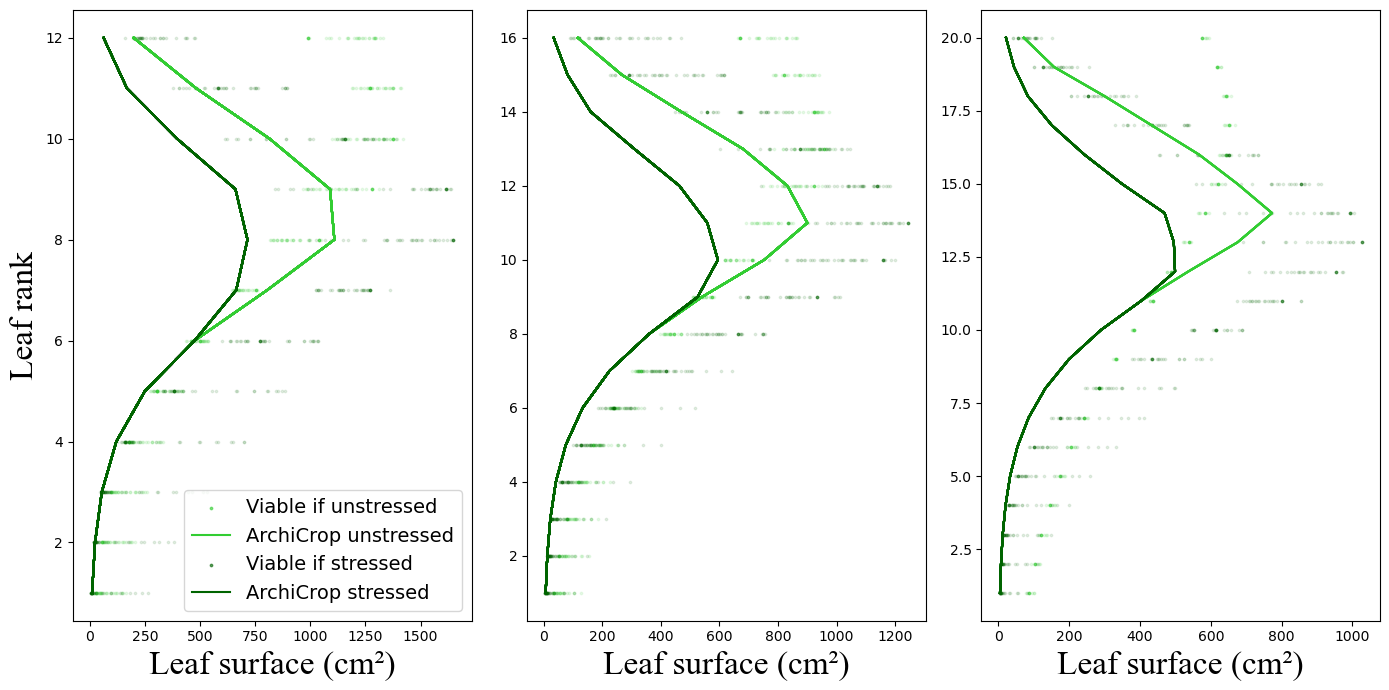

In [13]:
def linear_leaf_growth_and_pot(N, ligul_factor, pot_factor, rate=False):

    fig, ax = plt.subplots(1, len(N), figsize=(14, 7))
    
    for pot in [True, False]:
        if pot:
            stics_output_file='D:/ArchiCrop/data/mod_s02NT18SorgV2D1_no_stress.sti'
            color_stics = "orange"
            label_stics = "STICS unstressed"
            color_archicrop = "limegreen"
            label_archicrop = "ArchiCrop unstressed"
            label_viable = "Viable if unstressed"
        else:
            stics_output_file='D:/ArchiCrop/data/mod_s02NT18SorgV2D1.sti'
            color_stics = "orangered"
            label_stics = "STICS stressed"
            color_archicrop = "darkgreen"
            label_archicrop = "ArchiCrop stressed"
            label_viable = "Viable if stressed"
        density, daily_dynamics, lifespan, lifespan_early, thermal_time, leaf_area_plant, sen_leaf_area_plant, height_canopy, end_juv, end_veg, index_end_veg = stics_output(tec_file, plant_file, stics_output_file)

        if pot:
            pot_leaf_area = pot_factor * max(leaf_area_plant)
        
        for k, nb_phy in enumerate(N):
            # nb_phy = math.floor((end_veg-thermal_time[0]-ligulochron)/phyllochron)
            phyllochron = (end_veg-thermal_time[0])/(nb_phy + ligul_factor)
            ligulochron = phyllochron * ligul_factor
        
            leaf_area_plant = leaf_area_plant[:index_end_veg+1]
            thermal_time = thermal_time[:index_end_veg+1]
            spl = splrep(thermal_time, leaf_area_plant)
         
            starts = []
            ends = []
        
            for i in range(nb_phy):
                start = i * phyllochron + thermal_time[0]
                end = start + ligulochron
                
                starts.append(round(start))
                ends.append(round(end))
    
            la_starts = splev(starts, spl)
            la_ends = splev(ends, spl)
            leaf_areas = resolve_organ_growth(nb_phy, ligul_factor, la_ends)
            range_tt = range(round(thermal_time[0]), round(thermal_time[-1])+1)
            interp_la = splev(range_tt, spl)
            rates_la = [interp_la[i]-interp_la[i-1] if i > 0 else 0 for i in range(len(interp_la))]

            S = []
            for t in range(max(ends)):
                sum_temp = 0
                for i,(s,e) in enumerate(zip(starts,ends)):
                    if s <= t < e:
                        sum_temp += (t-s)/(e-s) * leaf_areas[i]
                    elif t >= e:
                        sum_temp += leaf_areas[i]
                S.append(sum_temp)
               
            for i, la in enumerate(leaf_areas):
                if la == max(leaf_areas):
                    id_max = i+1
                    break
        
            rmax_int = np.arange(max(0,(id_max-1)/nb_phy), min(1,(id_max+1)/nb_phy), 0.05)
           
            leaf_areas_norm = [la/max(leaf_areas) for la in leaf_areas]
        
            skews_rmax = {}
            id = 0
            for rank in range(1, nb_phy+1):
                for rmax in rmax_int:
                    if rmax != rank/nb_phy and leaf_areas[rank-1] > 0:
                        skew = compute_skew(rank=rank, nb_phy=nb_phy, rmax=rmax, leaf_areas=leaf_areas_norm)
                        if 1e-10 < skew < 1.0:
                            skews_rmax[id] = (skew, rmax)
                            id += 1

            skew_int = []
            rejected_skews = []
            label_green_set = False
            label_grey_set = False
            mtgs = {}
            for id,(skew,rmax) in skews_rmax.items():
                bell_shaped_leaf_areas = bell_shaped_dist(pot_leaf_area, nb_phy, rmax, skew)
                for i,bs in enumerate(bell_shaped_leaf_areas):
                    if bs < leaf_areas[i]: #-(0.05*max(leaf_areas)):
                        color = "grey"
                        break
                    else:
                        color = "black"
                if color == "black":
                    S = []
                    for t in range(max(ends)):
                        sum_temp = 0
                        for i,(s,e) in enumerate(zip(starts,ends)):
                            if s <= t < e:
                                sum_temp += (t-s)/(e-s) * bell_shaped_leaf_areas[i]
                            elif t >= e:
                                sum_temp += bell_shaped_leaf_areas[i]
                        S.append(sum_temp)
                    plant = ArchiCrop(daily_dynamics=daily_dynamics, leaf_area=pot_leaf_area, height=height_canopy[-1]*pot_factor, 
                                        nb_phy=nb_phy, phyllochron=phyllochron, leaf_duration=ligul_factor)
                    plant.generate_potential_plant()
                    growing_plant = plant.grow_plant(rate=rate, distribution_function=demand_dist)
                    growing_plant_mtg = list(growing_plant.values())
                    mtgs[id] = growing_plant_mtg
                if color == "black" and not label_green_set:
                    ax[k].scatter(bell_shaped_leaf_areas, range(1,nb_phy+1), color=color_archicrop, label=label_viable, s=3, alpha=0.6)
                    label_green_set = True
                elif color == "black":
                    ax[k].scatter(bell_shaped_leaf_areas, range(1,nb_phy+1), color=color_archicrop, s=3, alpha=0.1)
                # elif color == "grey" and not label_grey_set:
                #     ax2.plot(bell_shaped_leaf_areas, range(1,nb_phy+1), alpha=0, color=color) #, label="Non-viable")
                #     label_grey_set = True
                # else:
                #     ax2.plot(bell_shaped_leaf_areas, range(1,nb_phy+1), alpha=0, color=color)
                if color == "black":
                    skew_int.append(skew)
                else:
                    rejected_skews.append(skew)

            first = True
            for id in mtgs:
                visible_leaf_areas = []
                for leaf in mtgs[id][-32].properties()["visible_leaf_area"]:
                    visible_leaf_areas.append(mtgs[id][-32].properties()["visible_leaf_area"][leaf])
                if first:
                    ax[k].plot(visible_leaf_areas, range(1, nb_phy + 1), color=color_archicrop, label=label_archicrop)
                    first = False
                else:
                    ax[k].plot(visible_leaf_areas, range(1, nb_phy + 1), color=color_archicrop)

            ax[k].set_xlabel("Leaf surface (cm²)", fontsize=24, fontname="Times New Roman")

    ax[0].set_ylabel("Leaf rank", fontsize=24, fontname="Times New Roman")
    ax[0].legend(fontsize=14, loc="lower right")

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    today_str = date.today().strftime("%Y-%m-%d")
    os.makedirs(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}", exist_ok=True)  # noqa: PTH103
    plt.savefig(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}/leaf_growth_all_N_{nb_phy}_pot_factor_{pot_factor}_rate_{rate}.png")
    plt.show()

N = [12,16,20]
ligul_factor = 1.6
pot_factor = 1.45
linear_leaf_growth_and_pot(N, ligul_factor, pot_factor, rate=False)